<h1>Titanic - Machine Learning from Disaster 	&#128674;</h1>
<h2>A Kaggle Competition</h2>
<h3>Details</h3>
Explain a little more about the problem and the variables and put the link to the competion

### Import packages and data

In [140]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [122]:
#Reding the test and train data set
df = pd.read_csv("./Data/train.csv")
test_submit_df = pd.read_csv("./Data/test.csv")

<h3>So, first let's take a look on the train data</h3>

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [124]:
# Just to see the format and how is the dataframe is organized
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [125]:
#Looking for how much missing are in this df
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [126]:
#Dropping two rows with Embarked feature null
df.dropna(subset=["Embarked"], inplace=True)

<h3>So, first let's split data into train and test</h3>

In [127]:
X_train,X_test,y_train,y_test = train_test_split(df.drop("Survived",axis=1),df["Survived"],test_size=0.15,random_state=42)

<h2 style="color:#006600"> Working with the train dataset</h2>

###  Looking the distribuitions of data, mainly looking the age and fare statistics

In [128]:
X_train["Survived"] = y_train

In [129]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 315 to 103
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  755 non-null    int64  
 1   Pclass       755 non-null    int64  
 2   Name         755 non-null    object 
 3   Sex          755 non-null    object 
 4   Age          602 non-null    float64
 5   SibSp        755 non-null    int64  
 6   Parch        755 non-null    int64  
 7   Ticket       755 non-null    object 
 8   Fare         755 non-null    float64
 9   Cabin        173 non-null    object 
 10  Embarked     755 non-null    object 
 11  Survived     755 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 76.7+ KB


In [130]:
X_train[["Age","Fare"]].describe()

,Age,Fare
count,602.000000,755.000000
mean,29.904767,32.145750
std,14.820814,48.548195
min,0.420000,0.000000
25%,21.000000,7.895800
50%,28.250000,14.500000
75%,39.000000,31.275000
max,80.000000,512.329200


<h3>Looking close to the <i>Fare</i> variable

<AxesSubplot:>

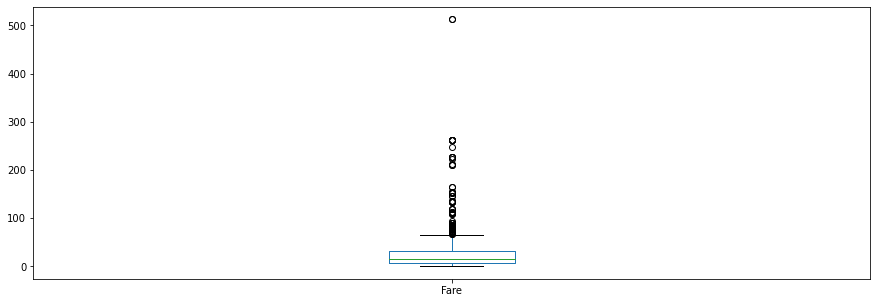

In [131]:
plt.Figure()
X_train["Fare"].plot(kind="box",figsize=(15,5))

Text(0.5, 0, 'Fare')

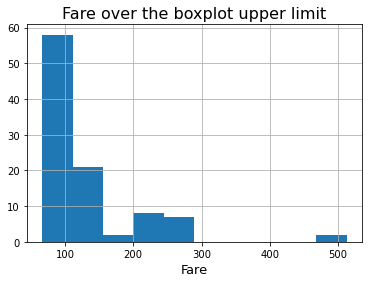

In [132]:
third_quantile = X_train["Fare"].quantile(0.75)
first_quantile = X_train["Fare"].quantile(0.25)
inter_quantile = third_quantile -first_quantile
plt.Figure()
X_train["Fare"][X_train["Fare"]>(third_quantile+1.5*inter_quantile)].hist()
plt.title("Fare over the boxplot upper limit",size=16)
plt.xlabel("Fare",size=13)

<p>13.3% of the Fare variable are over the boxplot upper limit. So, I decided to delete just the 3 max values (It represents 0,34%) and maintain the rest, as follows.

In [133]:
X_train.drop(X_train[X_train["Fare"]>400].index, inplace=True)
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
315,316,3,"Nilsson, Miss. Helmina Josefina",female,26.0,0,0,347470,7.8542,NaN,S,1
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,1
805,806,3,"Johansson, Mr. Karl Johan",male,31.0,0,0,347063,7.7750,NaN,S,0
345,346,2,"Brown, Miss. Amelia ""Mildred""",female,24.0,0,0,248733,13.0000,F33,S,1
49,50,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.0,1,0,349237,17.8000,NaN,S,0


<h3>Looking close to the <i>Age</i> variable

<h4>Some ideas to complete the missing:</h4>
<ul>
    <li>Separate age for child < 10, teens < 18 , adults < 45, elders > 45 (Considering the epoch)
    <li>Get the title from Name column
    <li>To fill the cabin I could try put one model using -1 and other dropping this column
    <li>To fill the age I could get the mean value, fill with -1 or to use the name (or other column) to try infer some relation like use the average age by sex.
</ul>


The age is well distributed, almost a normal curve, as we can see in the histogram below.

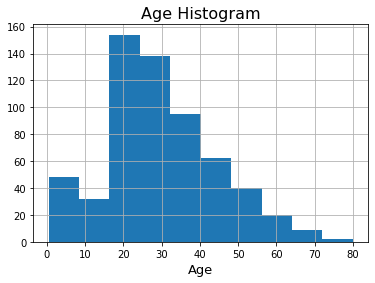

In [134]:
X_train["Age"].hist()
plt.title("Age Histogram",size=16)
plt.xlabel("Age",size=13)
plt.show()

## Defining the pipeline data transform

In [183]:
pipeline = Pipeline([
    ("age_fare",SimpleImputer(strategy="mean")),
    ("std_scaler",StandardScaler()),
])

pipeline_complete = ColumnTransformer([
    ("age_fare",pipeline,["Age","Fare"]),
    ("sex",OneHotEncoder(),["Sex","Embarked"]),
    ("rest","passthrough",["SibSp","Parch"]),
    ("dropped","drop",["PassengerId","Name","Ticket","Cabin"]),
])

## Transforming the train and test data